## **Project Final Report Group 46**

### **Introduction** ###



**Background Information** 

The Department of Computer Science at the University of British Columbia led by Dr. Frank Wood collected extensive data on Minecraft servers through the Lifelong PLAICraft study. Their research investigates player behaviours in video games in order to develop AI algorithms that can interact with players in a virtual gaming environment. The data was collected by creating custom Minecraft servers and recording game play. Using the `players.csv` dataset and the tools gained from their study we can implement our own predictive analyses to explore trends from the study’s participants. 

**Question**

Can age be used to predict whether or not players would subcribe to game-related newsletter in `players.csv` dataset, and is there a pattern related to player age? 

The `players.csv` datset can help address this question through discovering the age group of the target audience who are most likely to subscribe to game-related newsletters, and those who are less interested in the subscription. 

**Data Description**

### **Methods & Results** ###

The K-nearest neighbors classification algorithm will be used to address the question, predicting the subscription behavior on game-related newsletter of players. The k-nn classification algorithm is an appropriate method of approach as categorical class predictions (`subscribe`) would be made for new observations (players) based on other variables (`age`).

In [2]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Loading Data**

Start by loading in the `players.csv` file from our project GitHub data repository and store it in an object named `players`. 


In [3]:
players <- read_csv("https://raw.githubusercontent.com/zzashleeyj/DSCI100-46-Group-Project/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Data Wrangling**

Because the K-nearest neighbors model uses `Age` to predict `subscribe`, only these two variables should be present within the dataframe. In order to ensure consistency within the dataframe, `Age` is renamed to `age`. In addition, since k-nn regression can only be used to predict categorical data, `subscribe` must be converted from a logical type to a factor type.

In [4]:
players_tidy <- players |>
    select(subscribe, Age) |>
    mutate(subscribe = as_factor(subscribe)) |>
    rename(age = Age) |>
    drop_na()
players_tidy

subscribe,age
<fct>,<dbl>
TRUE,9
TRUE,17
FALSE,17
⋮,⋮
FALSE,22
FALSE,57
FALSE,17


**Summary Statistics**

Using the `players_tidy` dataset we will calculate summary statistics for the 2 variables relevant to our data analysis, `age` and `subscribe`.

In [5]:
age_mean <- players_tidy |>
    select(age) |>
    map_dfr(mean, na.rm = TRUE)
age_mean


age_range <- players_tidy |>
  summarize(
    min_age = min(age, na.rm = TRUE),
    max_age = max(age, na.rm = TRUE))
age_range


subscription_summary <- players_tidy |>
  count(subscribe)
subscription_summary

age
<dbl>
21.13918


min_age,max_age
<dbl>,<dbl>
9,58


subscribe,n
<fct>,<int>
FALSE,52
TRUE,142


**Summary Statistics Results**

Using the `players.csv` dataset we observe that the youngest study participant was 9 years old, the oldest was 58 and the average player age was approximately 21. In total 144 participants subscribed, while 52 chose not to. By computing the mean `age` and summarizing the distribution of the `subscribe` variable, we can get a better understanding of the data before building our prediction model.

**Exploratory Data Visualizations**

Histogram plots will be used to depict the relationship between each predictor and the `subscribe` variable to show which variable(s) may be the best for predicting whether or not players will subscribe to game-related newsletter. 

When creating histogram plots, `fill` will be used for the `subscribe` variable, in aesthetic mapping, so that each value within the `subscribe` variable will be grouped by colour. In the `geom_histogram` function, `stat = "count"` is used to count how many times each value appears in the x variable. Additionally, the `facet_grid` function will be used to create subplots so that the two group of subscribers (i.e. "TRUE" or "FALSE") can be seen clearly in their own plot.  

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


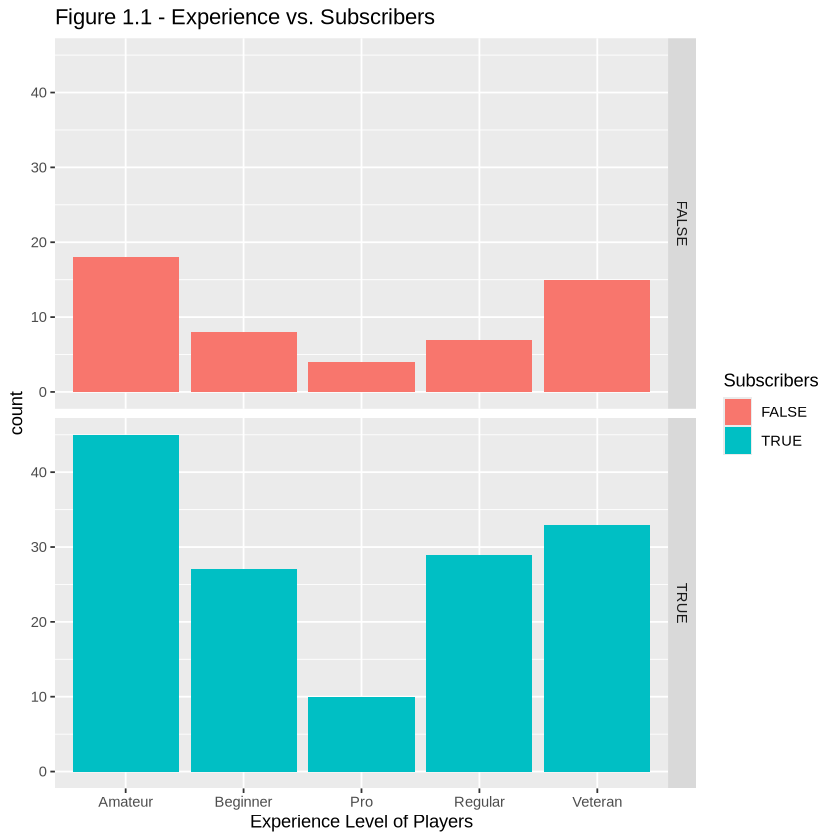

In [8]:
experience_plot <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_histogram(stat = "count") + 
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Experience Level of Players", fill = "Subscribers") +
    ggtitle("Figure 1.1 - Experience vs. Subscribers")
experience_plot


**Figure 1.1.** The experience level of players and their subscription behaviour to game-related newsletters are shown through a histogram plot. Players who are not subscribed to game-related newsletters are shown in red. Players who are subscribed to game-related newsletters are shown in blue. 



Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


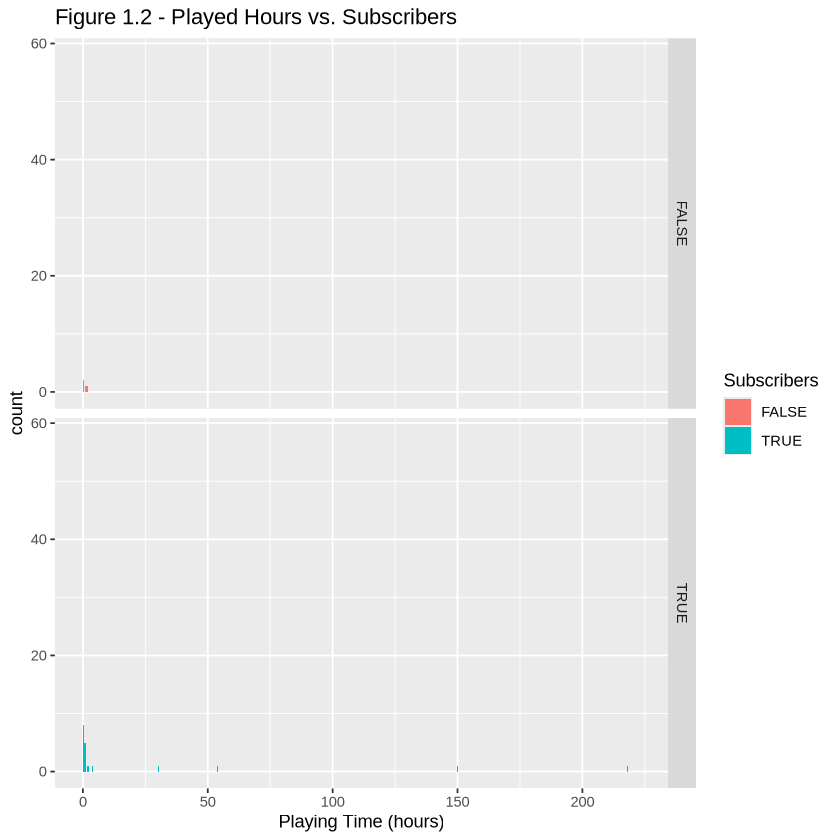

In [10]:
played_hours_plot <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(stat = "count") + 
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Playing Time (hours)", fill = "Subscribers") +
    ggtitle("Figure 1.2 - Played Hours vs. Subscribers")
played_hours_plot


**Figure 1.2.** The playing time of players, in hours, and their subscription behaviour to game-related newsletters through a histogram plot. The small red bands shown on the left side of the top graph represents players who are not subscribed to game-related newsletters. The small blue bands on the left side bottom graph represents players who are subscribed to game-related newsletters. 


Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


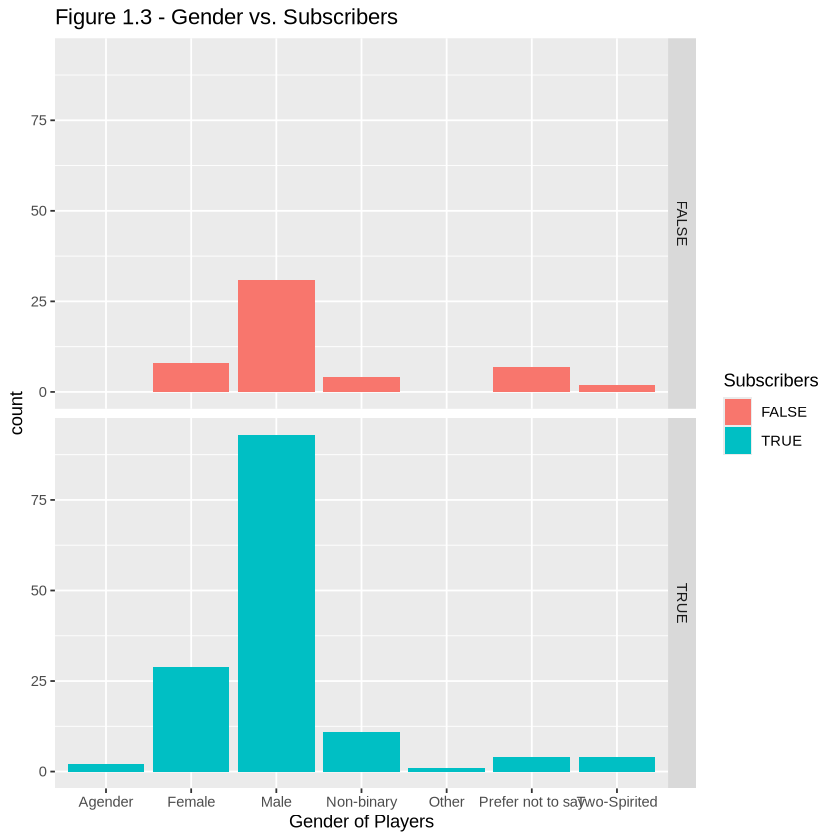

In [12]:
gender_plot <- ggplot(players, aes(x = gender, fill = subscribe)) +
    geom_histogram(stat = "count") + 
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Gender of Players", fill = "Subscribers") +
    ggtitle("Figure 1.3 - Gender vs. Subscribers")
gender_plot

**Figure 1.3.** The gender of players and their subscription behaviour to game-related newsletters are shown through a histogram plot. On the top graph, those who are not subscribed to game-related newsletters are shown in red and those who are subscribed to game-related newsletters are shown in blue, on the bottom graph.

Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


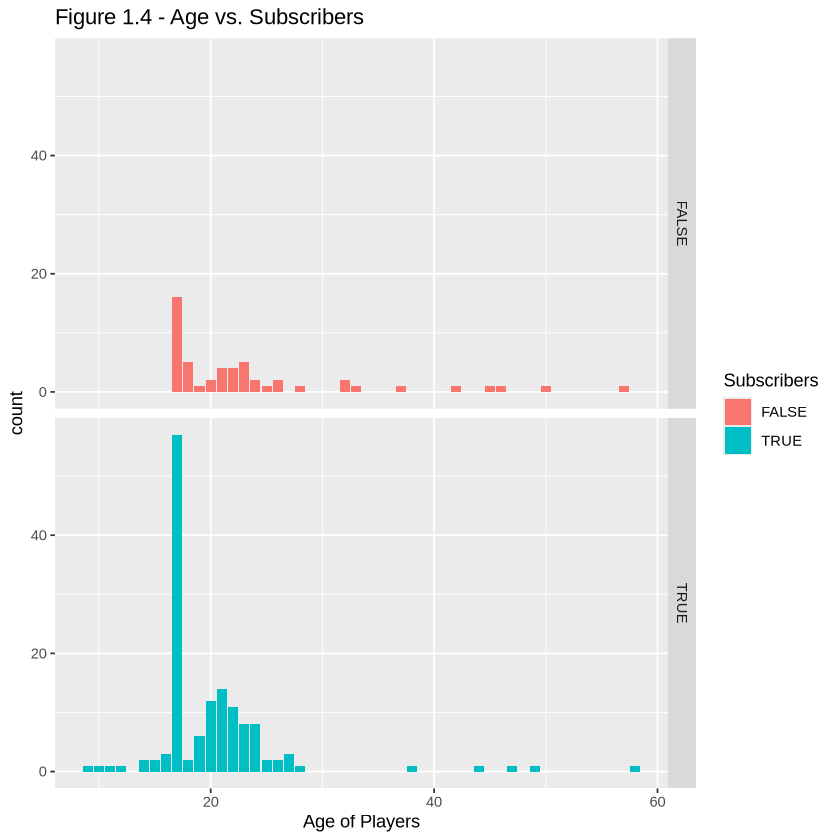

In [13]:
age_plot <- ggplot(players, aes(x = Age, fill = subscribe)) +
    geom_histogram(stat = "count") + 
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Age of Players", fill = "Subscribers") +
    ggtitle("Figure 1.4 - Age vs. Subscribers")
age_plot

**Figure 1.4.** The age of players and their subscription behaviour to game-related newsletters are shown through a histogram plot. The players who are not subscribed to game-related newsletters are shown on the top graph in red. The players who are subscribed to game-related newsletters are shown on the bottom graph in blue.

*Experience vs. Subscribers Plot*

The `experience` variable only contains 5 different categories, which may not be enough data to reliably categorize subscription behavior of players.

*Played Hours vs. Subscribers Plot*

The `played_hours` variable contains too many categories. The large amount of data that needs to be taken into consideration when categorizing subscription behaviour can cause the k-nn classification algorithm to slow down. 

*Gender vs. Subscribers Plot*

The `gender` variable only contains 7 different categories. The small amount of data available may not be reliable enough to accurately catergorize subscription behaviour of players.

*Age vs. Subscribers Plot*

The `age` variable seems to contain a proper amount of data, as the ages ranges from around 10 to 60 years old. It may contain enough data to reliably categorize the subscription behavior of players, and will not cause the k-nn algorithm to slow down. 

Overall, the the `age` variable may be the best to predict whether or not players would subscribe to game-related newsletters. 

**Training Dataset**

Now that the predictor variable has been determined, `age`, the dataset will be split into a training and testing set to ensure that the k-nn classification is making accurate predictions for the new observations. 

However, a seed value needs to be set to ensure that the dataset is being split randomly, without bias. The function `set.seed` will be used to create this randomness in the splitting of the data set. 


In [14]:
set.seed(1)

The dataset will be split with 75% of the data used for the training set and 25% of the data used for the testing set. The `initial_split` function will be used shuffle the whole dataset before splitting, and the `subscribe` variable will be stratified to ensure equal amounts of values from the `subscribe` variable shows up in both the training and testing dataset. Then the `testing` and `training` function will be used to split the dataset.

In [15]:
set.seed(1)
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe) 
players_train <- training(players_split)
players_test <- testing(players_split)

players_train
players_test

subscribe,age
<fct>,<dbl>
FALSE,17
FALSE,22
FALSE,17
⋮,⋮
TRUE,17
TRUE,17
TRUE,17


subscribe,age
<fct>,<dbl>
TRUE,21
TRUE,21
TRUE,17
⋮,⋮
TRUE,20
FALSE,57
FALSE,17


Furthermore, the `subscribe` class must be balanced, in order to ensure that there does not exist a label with a much greater number of data points.

In [16]:
num_obs <- nrow(players_train)
subscribe_percentage <- players_train |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

subscribe_percentage

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


From the table, there is a higher percentage of subscribed users. As a result, the k-nn classification model is much more likely to predict a value of `TRUE` for `subscribe`. To account for this issue, the `step_upsample` function is used in the recipe, rebalancing the data by oversampling the `False` class. Finally, the training dataset will be standardized by using `step_scale` and `step_center` functions it to ensure that all values within the training dataset equally influences the k-nn classification algorithm.

In [17]:
set.seed(2)

train_recipe <- recipe(subscribe ~ age, data = players_train) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Before a model specification can be created, the k-nn classification model needs to be tuned, meaning that the best value of K must be chosen. 

Cross-validation will be perfomed using the `vfold_cv` function, where the `subscribe` variable will be stratified and the training data will be split into`v` folds. 

A temporary model specification, with K = 30, will be made to determine the number of folds that will be conducted in the cross-validation. The `weight_func = "rectangular"` argument ensures that each K nearest neighbor has only 1 vote for the classification of new observations. The method used and type of problem is specified under`set_engine`and `set_mode`, respectively.

The `fit_resamples` function will be used to perform cross-validation on each validation split.

In [18]:
set.seed(2)

train_vfold_5 <- vfold_cv(players_train, v = 5, strata = subscribe)

knn_spec_5 <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold_metrics_5 <- workflow() |>
    add_recipe(train_recipe) |>
    add_model(knn_spec_5) |>
    fit_resamples(resamples = train_vfold_5) |>
    collect_metrics()
vfold_metrics_5


train_vfold_10 <- vfold_cv(players_train, v = 10, strata = subscribe)

knn_spec_10 <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold_metrics_10 <- workflow() |>
    add_recipe(train_recipe) |>
    add_model(knn_spec_10) |>
    fit_resamples(resamples = train_vfold_10) |>
    collect_metrics()
vfold_metrics_10

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.3464204,5,0.03812260,Preprocessor1_Model1
roc_auc,binary,0.4698361,5,0.03813994,Preprocessor1_Model1


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.3368864,10,0.02685937,Preprocessor1_Model1
roc_auc,binary,0.4822727,10,0.04146757,Preprocessor1_Model1


A 5-fold cross validation has an estimated mean of 0.35 and a standard error of 0.038. A 10-fold cross validation has an estimated mean of 0.33 and a standard error of 0.027. Thus, a 5-fold cross validation would be performed as it provides a higher accuracy estimate of around 35%. 

However, the estimated classifier accuracy of 35% can be further improved by choosing the best K value. 

The function `tune` will be used in the model specification to tune each parameter (K value). 


In [19]:
set.seed(2)

train_vfold_5 <- vfold_cv(players_train, v = 5, strata = subscribe)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


A `k_vals` data frame is used to store K values from 1 to 100 in the `neighbors` variable. The function `tune_grid` will be used to fit the model to each K value in the `k_vals` data frame.

A plot is created to determine the best K value based on highest accuracy.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3033826,5,0.02475299,Preprocessor1_Model01
6,accuracy,binary,0.3174056,5,0.01737302,Preprocessor1_Model02
11,accuracy,binary,0.3309524,5,0.01281446,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.5859770,5,0.04535557,Preprocessor1_Model18
91,accuracy,binary,0.6000164,5,0.04130261,Preprocessor1_Model19
96,accuracy,binary,0.6285878,5,0.04004536,Preprocessor1_Model20


[1] 76

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
76,accuracy,binary,0.642381,5,0.06034821,Preprocessor1_Model16


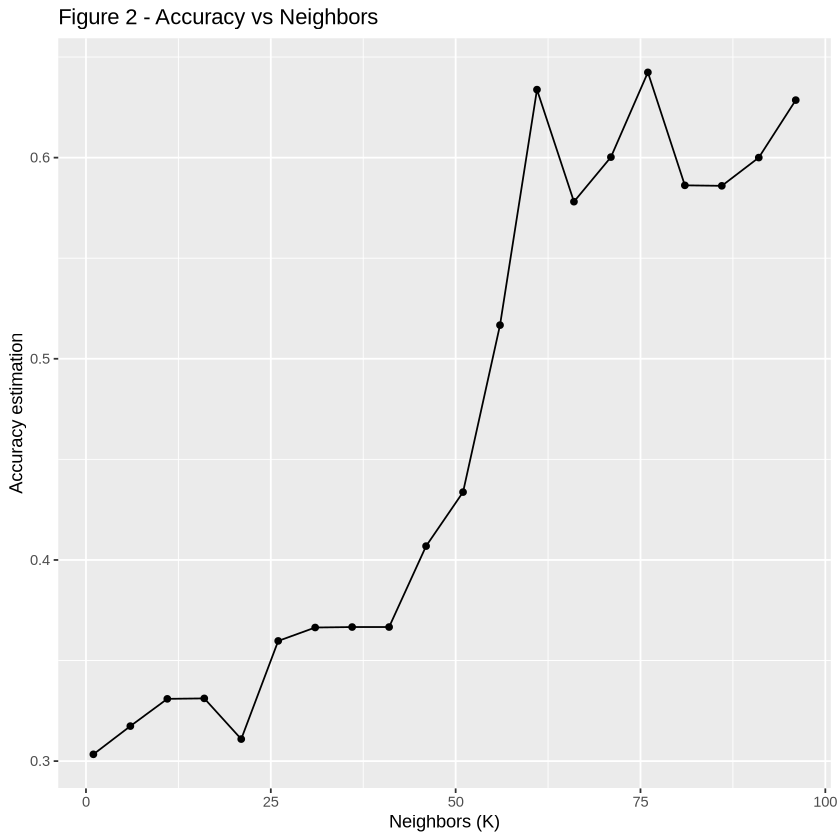

In [21]:
set.seed(2)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

training_knn_results <- workflow () |>
    add_recipe(train_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = train_vfold_5, grid = k_vals) |> 
    collect_metrics()

accuracies <- training_knn_results |>
    filter(.metric == "accuracy")
accuracies

accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors (K)", y = "Accuracy estimation") +
    ggtitle("Figure 2 - Accuracy vs Neighbors")
accuracy_plot

best_k <- accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

best_k_accuracy <- training_knn_results |>
    filter(.metric == "accuracy") |>
    filter(neighbors == "76" )
best_k_accuracy

**Figure 2.** The estimation accuracy of the number of neighbours (K) is shown through a scattered line plot. The neighbours with the highest estimation accuracy are shown at the top of the plot.


The best K value is 76, providing the highest cross-validation accuracy estimation of 64%.
Now, the k-nn classification algorithm will be retrained using K = 76.

In [14]:
set.seed(2) 

knn_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(train_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(76,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4764151
Best kernel: rectangular
Best k: 76

**Testing Dataset**

The k-nn classification object is ready to be used to predict the labels of the testing dataset. We use the `bind_cols` to add the column of predictions to the original test data, creating the `subscribe_test_predictions` data frame.

In [15]:
subscribe_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

subscribe_test_predictions

.pred_class,subscribe,age
<fct>,<fct>,<dbl>
TRUE,TRUE,21
TRUE,TRUE,21
FALSE,TRUE,17
⋮,⋮,⋮
TRUE,TRUE,20
FALSE,FALSE,57
FALSE,FALSE,17


From the `levels` function, the `TRUE` class is the second factor level. Since this is the positive class, `event_level = "second"` should be used when calculating accuracy, precision, and recall. 

In [16]:
subscribe_test_predictions |> pull(subscribe) |> levels()

[1] "FALSE" "TRUE"

Now, the classifier is ready for evaluation. Using the `metrics` function, accuracy is calculated. Then, precision and recall are calculated using the `precision` and `recall` functions from `tidymodels`.  

In [17]:
subscribe_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

subscribe_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

subscribe_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5306122


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7826087


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5


From the given tables, accuracy, precision, and recall are determined to be 53%, 78%, and 50%, respectively. Finally, we can look at the confusion matrix for the classifier using the `conf_mat` function.

In [18]:
confusion <- subscribe_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     8   18
     TRUE      5   18

There are 18 players that have been correctly predicted as being subscribers, and 8 players correctly predicted as not being subscribers. However, the classifier predicted that 5 non-subscribers were subscribed and that 18 subscribers were not subscribed. 

In order to evaluate the performance of the classifier, the accuracy can be compared to the majority classifier. The percentage of players who are subscribed is calculated to be 73%.

In [19]:
total_num_obs <- nrow(players)
total_subscribe_percentage <- players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

total_subscribe_percentage

subscribe,count,percentage
<lgl>,<int>,<dbl>
FALSE,52,35.86207
TRUE,144,99.31034


Clearly, the classifier's accuracy of 50% is lower than that of the majority classifier. Thus, it can be concluded that the 

**Visualization Analysis**

In order to understand our results it is important to see exactly what the test set predicted using our model. We will use the `subscribe_test_predictions` data and create a scatter plot using `geom_point`.

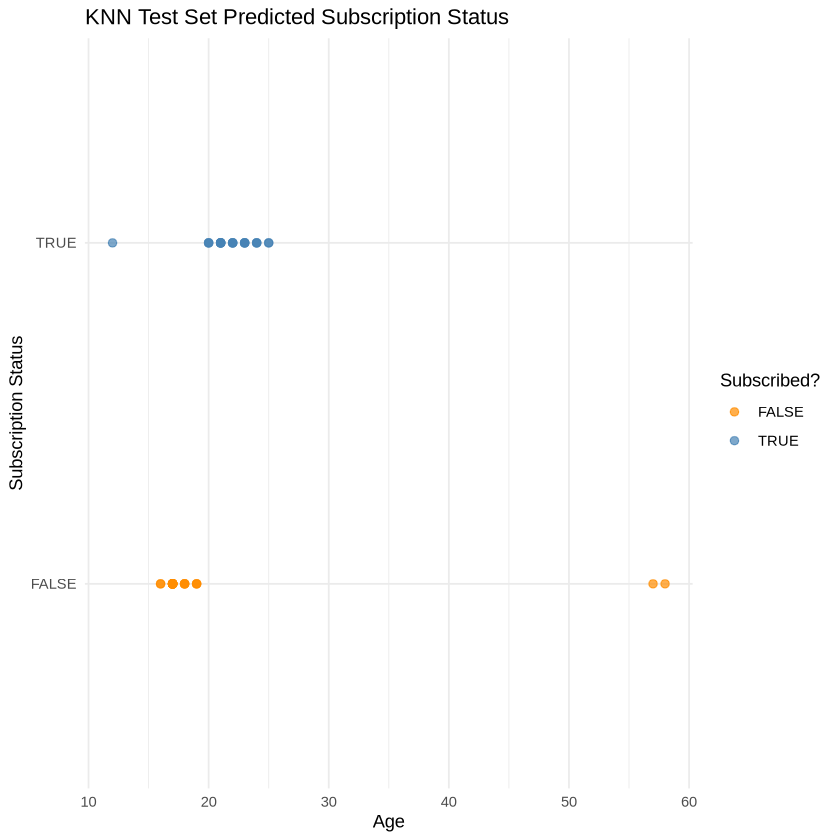

In [25]:
knn_test_predicted_plot<- ggplot(subscribe_test_predictions,
                             aes(x = age,
                                 y = .pred_class,
                                 color =.pred_class)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(x = "Age",y = "Subscription Status",title = "KNN Test Set Predicted Subscription Status", color= "Subscribed?") +
  scale_color_manual(values = c("darkorange", "steelblue"))+
  theme_minimal()

knn_test_predicted_plot

In order to visually evaluate how **well** our classification system performed on the testing data,  we will use green points to represent correctly predicted observations and red points represent incorrect predictions. Each point in the `knn_prediction_validity` corresponds to one player in the test set, this allows us to clearly see where the classifier succeeded and where it made errors.

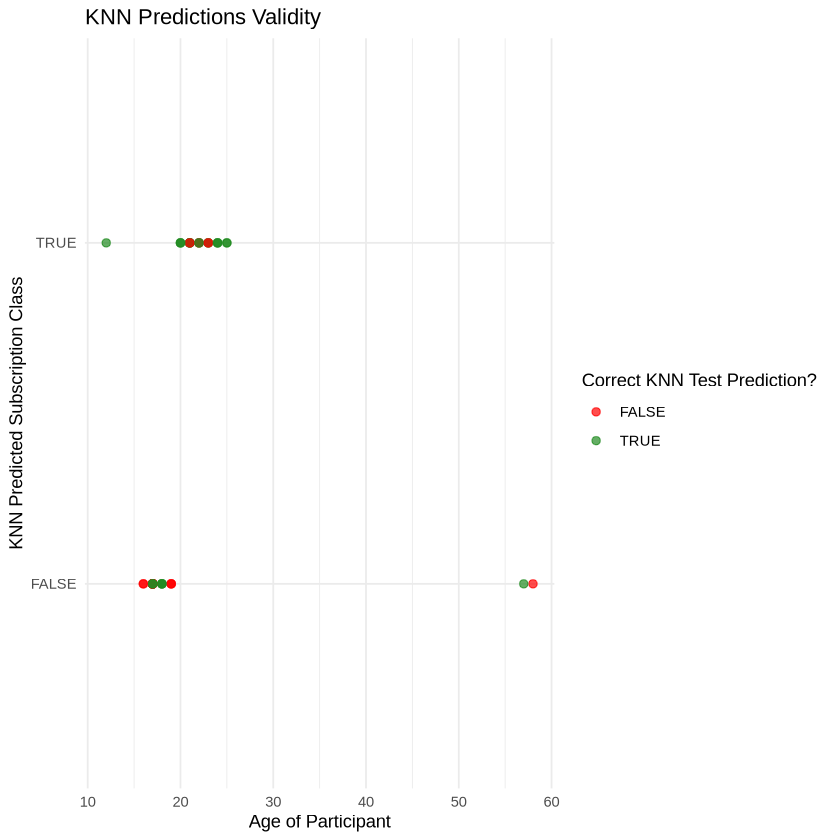

In [23]:

classified <- subscribe_test_predictions |>
mutate(correct = .pred_class == subscribe)

knn_prediction_validity_plot<-ggplot(classified, aes(x = age, y = .pred_class, color = correct)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(
    x = "Age of Participant",
    y = "KNN Predicted Subscription Class",
    color = "Correct KNN Test Prediction?",
    title = "KNN Predictions Validity"
  ) +
 scale_color_manual(values = c("TRUE" = "forest green", "FALSE" = "red"))+
  theme_minimal()

knn_prediction_validity_plot 


In [24]:
confusion <- subscribe_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     8   18
     TRUE      5   18


**Discussion**

*Summary*

The plots `knn_test_predicted_plot` and `knn_prediction_validity_plot` above display the predicted player subscription status generated by our KNN classifier on the testing dataset, which was created from our initial training data using the value K = 76. Since we are using only one predictor`age` and our outcome `subscribe` has two possible categories (“TRUE or FALSE”), our model can be considered a binary classification problem.

By visualizing these predictions on mutiple plots we can observe that our model was not able to create a clear seperation between subscribers and non subscibers. The presence of many red coloured points in the `knn_prediction_validity_plot` plot indicates a high number of incorrectly classified observations. This pattern is consistent with the confusion matrix stored in the `confusion` object, where we also see a large number of misclassified players. 

These results suggest that `age` alone is not a strong predictor of subscription status from the `players.csv` dataset. 

*Expectations*


*Impact*

The data displayed from the `knn_prediction_validity_plot` and the confusion matrix showed that a high number of observations, `players`, were misclassified. Additionally, the k-nn classification algorithm produced a low estimation accuracy of 64%. These findings suggests that the variable `age` may not be the best variable to categorize subscription behaviour of players. With the high number of misclassified players, a solid conclusion can not be drawn on player subscription behvaiour. Therefore, future investigations are needed to determine other variable(s) that may be able to determine subscription behaviour of players. 


*Future Questions*



**References**